In [1]:
using DataFrames
using Gadfly
using Compose
using Cairo
using LsqFit
set_default_plot_size(30cm, 12cm)

In [2]:
# Get ready
home = "/home/german/labo/17/cph_obp/"
cph_outputs = string(home, "run/eol/data/outputs/")
eol_cph_outputs = string(home, "run/eol/data/cph_outputs/")

ph_range = collect(30:5:75)

suffix_pka_file = "_pka"
suffix_pop_file = "_pop"

titrable_cnt = 36
protonated_fraction = Array{Float64, 2}(titrable_cnt, length(ph_range))
deprotonated_fraction = Array{Float64, 2}(titrable_cnt, length(ph_range));

global const def_pka_as4 = 3.71
global const def_pka_gl4 = 4.15
global const def_pka_lys = 10.67
global const def_pka_hip = 6.04;
global const def_pka_cyx = 8.14;
global const def_pka_tyr = 10.1;

### Leyendo de las pop

i = 0
for ph in ph_range
    i+=1
    pop_filename = string(eol_cph_outputs, ph, suffix_pop_file)
    pop_file = readdlm(pop_filename, header = true)[1][2:end, 2:end]
    if i == 1
        global titrable_resnames = convert(Array{String}, pop_file[:, 1]) # const
        global titrable_resis = convert(Array{Int64}, pop_file[:, 2]) # const
    end

    k = 0
    for resname in titrable_resnames
        k+=1
        if resname == "GL4"
            deprotonated_fraction[k, i] = pop_file[k, 3:end][1]
        elseif resname == "AS4"
            deprotonated_fraction[k, i] = pop_file[k, 3:end][1]
        elseif resname == "HIP"
            deprotonated_fraction[k, i] = pop_file[k, 3:end][1]
        elseif resname == "LYS"
            deprotonated_fraction[k, i] = pop_file[k, 3:end][1]
        end
    end            
end

### Leyendo de las pka

In [3]:
i = 0
for ph in ph_range
    i+=1
    pka_filename = string(eol_cph_outputs, ph, suffix_pka_file)
    pka_file = readdlm(pka_filename, header = true)[1][1:end-1, 1:end-1]
    
    if i == 1
        global titrable_resnames = convert(Array{String}, pka_file[:, 1]); # const
        global titrable_resis = convert(Array{Int64}, pka_file[:, 2]); # const
    end

    protonated_fraction[:, i] = pka_file[:, end-1];
end
deprotonated_fraction = 1 - protonated_fraction;

# Get array with default pkas for each titrable resodie
titrable_def_pka = Array{Float64}(length(titrable_resis))
for i = 1:length(titrable_resis)
    resname = titrable_resnames[i]
    if resname == "GL4"
        titrable_def_pka[i] = def_pka_gl4
    elseif resname == "AS4"
        titrable_def_pka[i] = def_pka_as4
    elseif resname == "HIP"
        titrable_def_pka[i] = def_pka_hip
    elseif resname == "LYS"
        titrable_def_pka[i] = def_pka_lys
    end
end

In [4]:
# Data previo. p[2] será reemplazado por el pka default
titrable_ns = Array{Float64}(length(titrable_resis))
titrable_pkas = Array{Float64}(length(titrable_resis))
titrable_curves = Array{Function}(length(titrable_resis))

model(x, p) = 1 ./ (1 + 10 .^(p[1]*(p[2] - x)) )
xdata = ph_range ./ 10
p = [1.0 ; 6.0]

x = collect(0.0:0.1:14.0);

In [5]:
# Obtengo las titration curves y los pkas
for i = 1:length(titrable_resis)
    if titrable_resnames[i] == "GL4"
        p[2] = def_pka_gl4
    elseif titrable_resnames[i] == "AS4"
        p[2] = def_pka_as4
    elseif titrable_resnames[i] == "HIP"
        p[2] = def_pka_hip
    elseif titrable_resnames[i] == "LYS"
        p[2] = def_pka_lys
    end
    ydata = deprotonated_fraction[i, :];
    fit = curve_fit(model, xdata, ydata, p)
    titrable_ns[i] = fit.param[1]
    titrable_pkas[i] = fit.param[2]
    titrable_curve(x) = 1 ./ (1 + 10 .^ (fit.param[1] .* (fit.param[2] - x)) )
    
    titrable_curves[i] = titrable_curve;
end

# Guardo los pkas obtenidos
df_titrable_eol = DataFrame(resname = titrable_resnames, resi = titrable_resis, pka = round.(titrable_pkas, 2))
writetable(string(home, "rtdos_log/pka_eol"), df_titrable_eol, separator = '\t');

### Diferencias

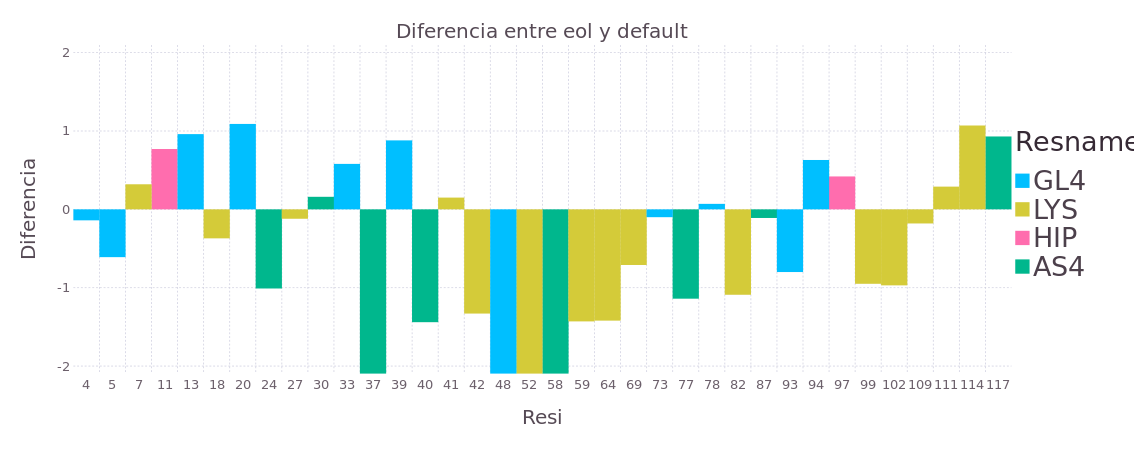

In [48]:
df_dif_eol_def = DataFrame(Resname = titrable_resnames, Resi = titrable_resis,
    Diferencia = df_titrable_eol[:pka] - titrable_def_pka)

plot(df_dif_eol_def, Geom.bar, x = "Resi", y = "Diferencia", color = "Resname",
    Scale.x_discrete,
    Guide.title("Diferencia entre eol y default"),
    Coord.cartesian(ymin = -2, ymax = 2),
    Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
        key_title_font_size=20pt, key_label_font_size=20pt))

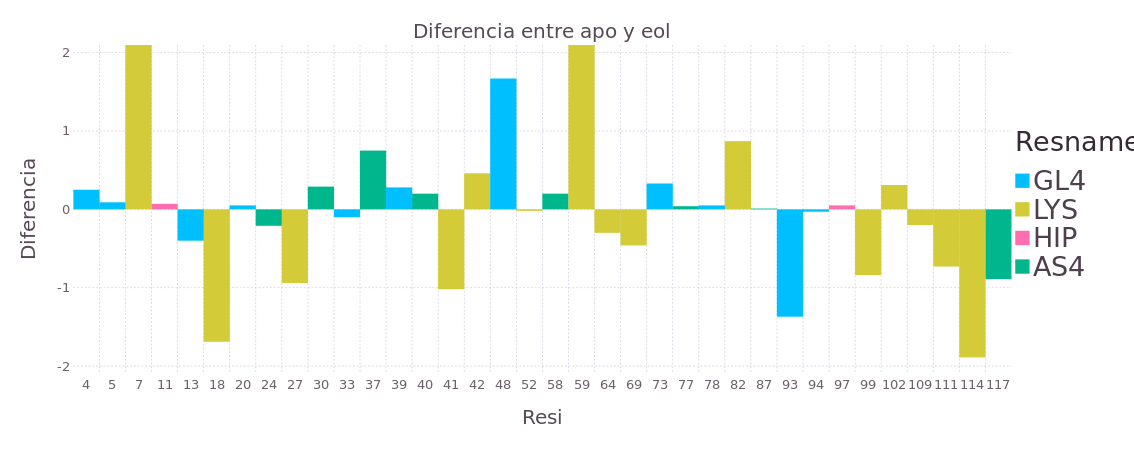

In [7]:
df_titrable_apo = readtable(string(home, "rtdos_log/pka_apo"), separator = '\t')
df_dif_apo_eol = DataFrame(Resname = titrable_resnames, Resi = titrable_resis,
    Diferencia = df_titrable_apo[:pka] - df_titrable_eol[:pka])

plot(df_dif_apo_eol, Geom.bar, x = "Resi", y = "Diferencia", color = "Resname",
    Scale.x_discrete,
    Guide.title("Diferencia entre apo y eol"),
    Coord.cartesian(ymin = -2, ymax = 2),
    Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
        key_title_font_size=20pt, key_label_font_size=20pt))

In [8]:
df_dif_apo_eol[sortperm(abs(df_dif_apo_eol[:Diferencia]), rev = true), :][10:20, :]

11×3 DataFrames.DataFrame
│ Row │ Resname │ Resi │ Diferencia │
├─────┼─────────┼──────┼────────────┤
│ 1   │ "LYS"   │ 82   │ 0.87       │
│ 2   │ "LYS"   │ 99   │ -0.84      │
│ 3   │ "AS4"   │ 37   │ 0.75       │
│ 4   │ "LYS"   │ 111  │ -0.73      │
│ 5   │ "LYS"   │ 42   │ 0.46       │
│ 6   │ "LYS"   │ 69   │ -0.46      │
│ 7   │ "GL4"   │ 13   │ -0.4       │
│ 8   │ "GL4"   │ 73   │ 0.33       │
│ 9   │ "LYS"   │ 102  │ 0.31       │
│ 10  │ "LYS"   │ 64   │ -0.3       │
│ 11  │ "AS4"   │ 30   │ 0.29       │

In [9]:
df_titrable_apo[sortperm(abs(df_dif_apo_eol[:Diferencia]), rev = true), :][10:20, :]

11×3 DataFrames.DataFrame
│ Row │ resname │ resi │ pka   │
├─────┼─────────┼──────┼───────┤
│ 1   │ "LYS"   │ 82   │ 10.45 │
│ 2   │ "LYS"   │ 99   │ 8.88  │
│ 3   │ "AS4"   │ 37   │ 2.3   │
│ 4   │ "LYS"   │ 111  │ 10.23 │
│ 5   │ "LYS"   │ 42   │ 9.8   │
│ 6   │ "LYS"   │ 69   │ 9.5   │
│ 7   │ "GL4"   │ 13   │ 4.71  │
│ 8   │ "GL4"   │ 73   │ 4.38  │
│ 9   │ "LYS"   │ 102  │ 10.01 │
│ 10  │ "LYS"   │ 64   │ 8.95  │
│ 11  │ "AS4"   │ 30   │ 4.16  │

In [10]:
df_titrable_eol[sortperm(abs(df_dif_apo_eol[:Diferencia]), rev = true), :][10:20, :]

11×3 DataFrames.DataFrame
│ Row │ resname │ resi │ pka   │
├─────┼─────────┼──────┼───────┤
│ 1   │ "LYS"   │ 82   │ 9.58  │
│ 2   │ "LYS"   │ 99   │ 9.72  │
│ 3   │ "AS4"   │ 37   │ 1.55  │
│ 4   │ "LYS"   │ 111  │ 10.96 │
│ 5   │ "LYS"   │ 42   │ 9.34  │
│ 6   │ "LYS"   │ 69   │ 9.96  │
│ 7   │ "GL4"   │ 13   │ 5.11  │
│ 8   │ "GL4"   │ 73   │ 4.05  │
│ 9   │ "LYS"   │ 102  │ 9.7   │
│ 10  │ "LYS"   │ 64   │ 9.25  │
│ 11  │ "AS4"   │ 30   │ 3.87  │

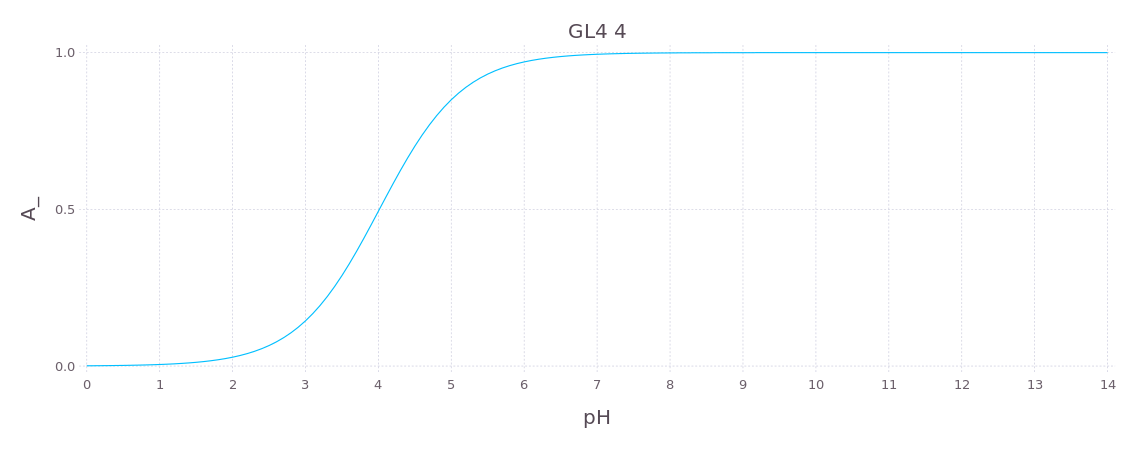

In [11]:
i = 1
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

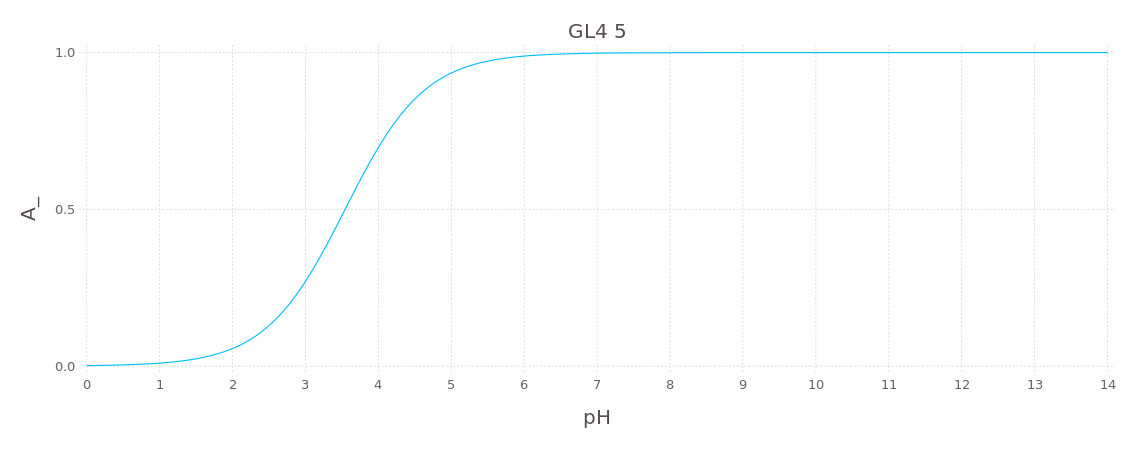

In [12]:
i = 2
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

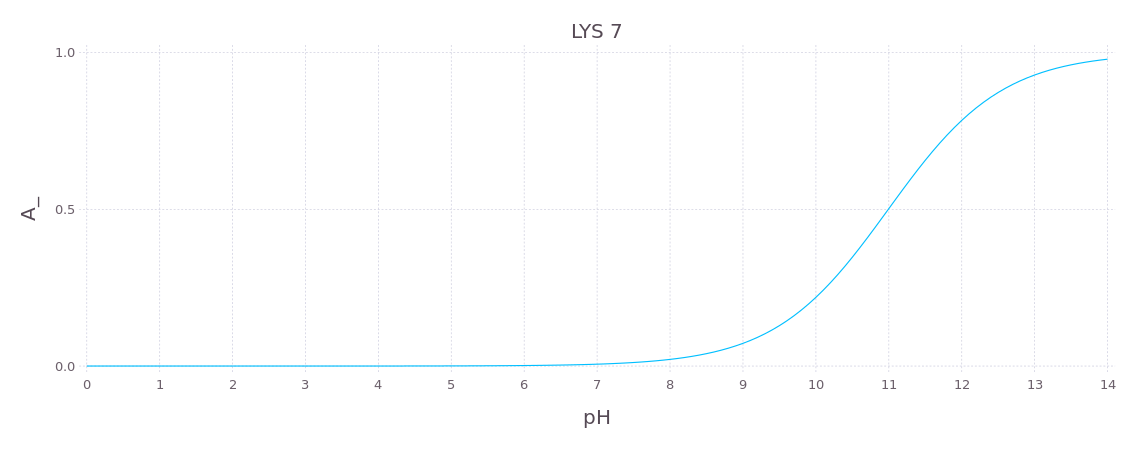

In [13]:
i = 3
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

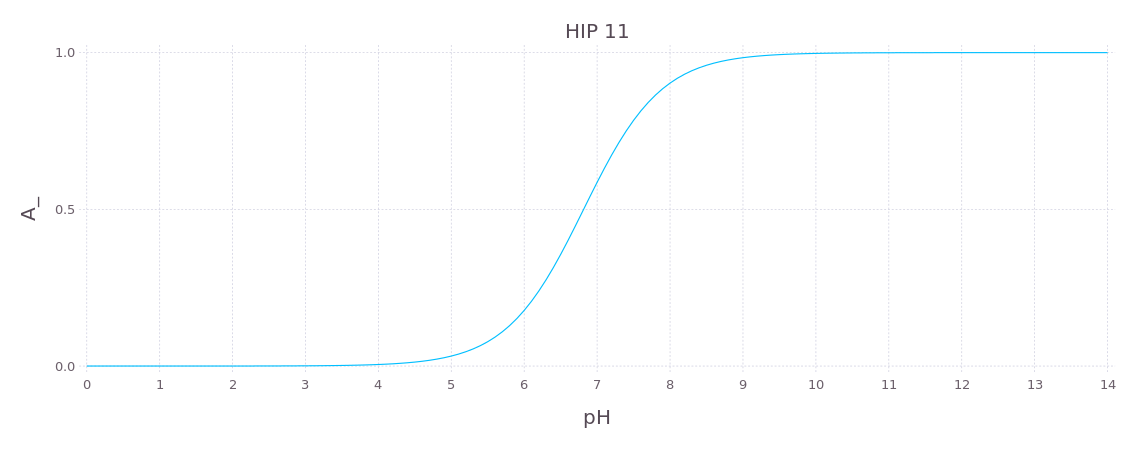

In [14]:
i = 4
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

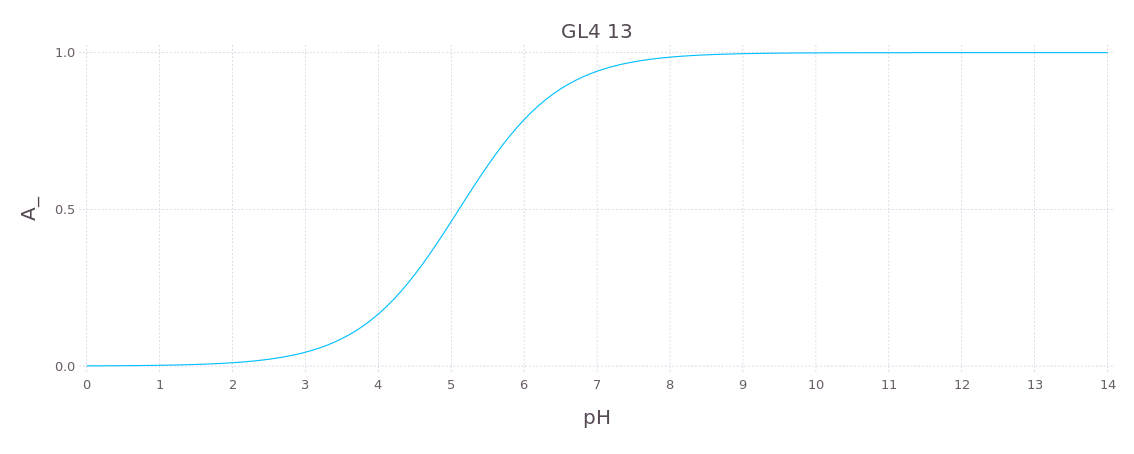

In [15]:
i = 5
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

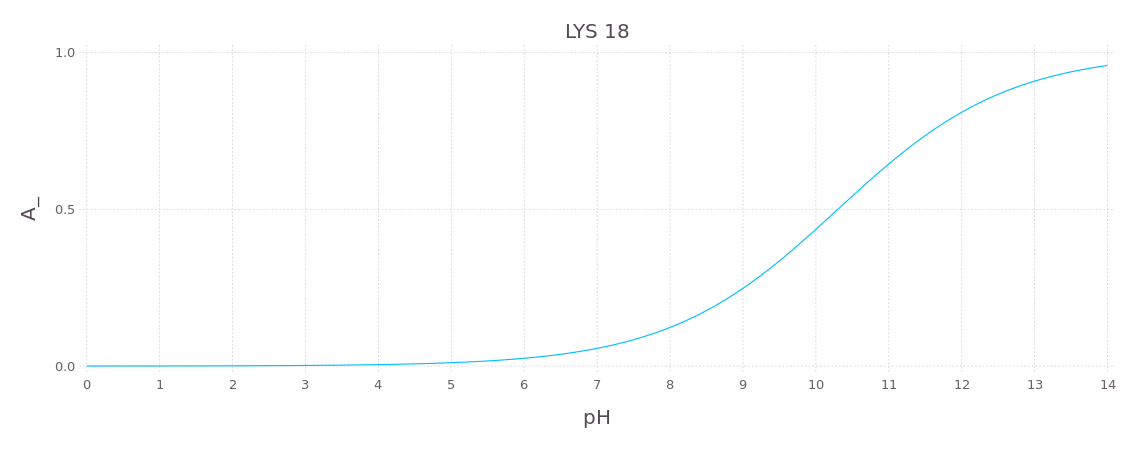

In [16]:
i = 6
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

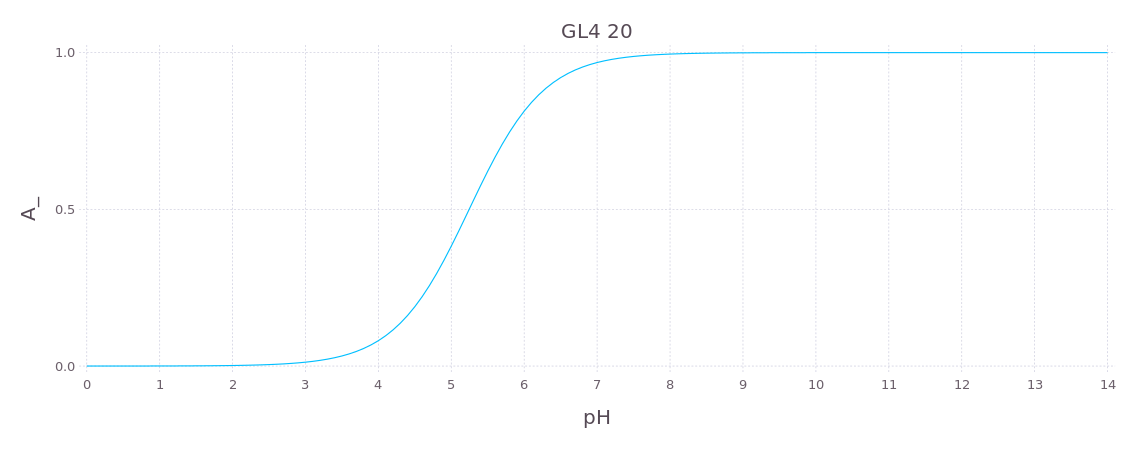

In [17]:
i = 7
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

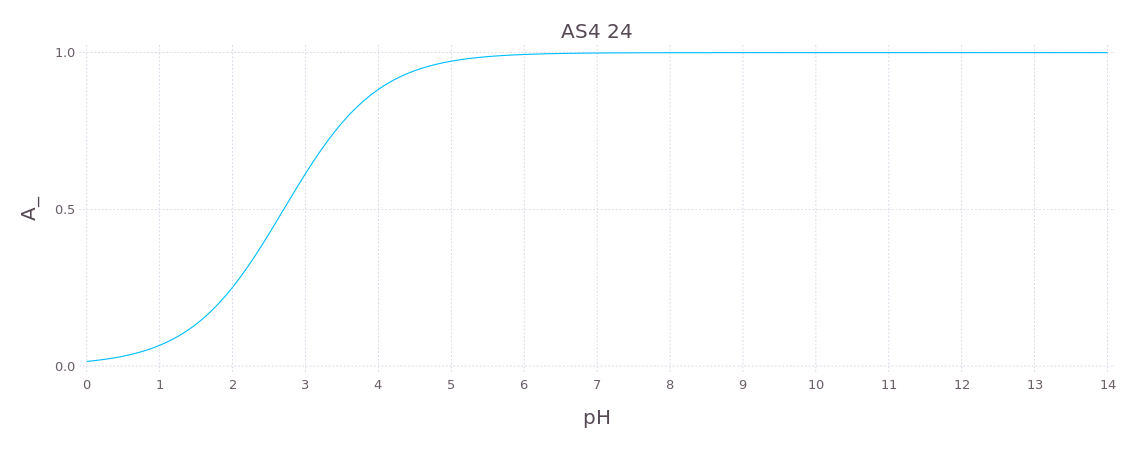

In [18]:
i = 8
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

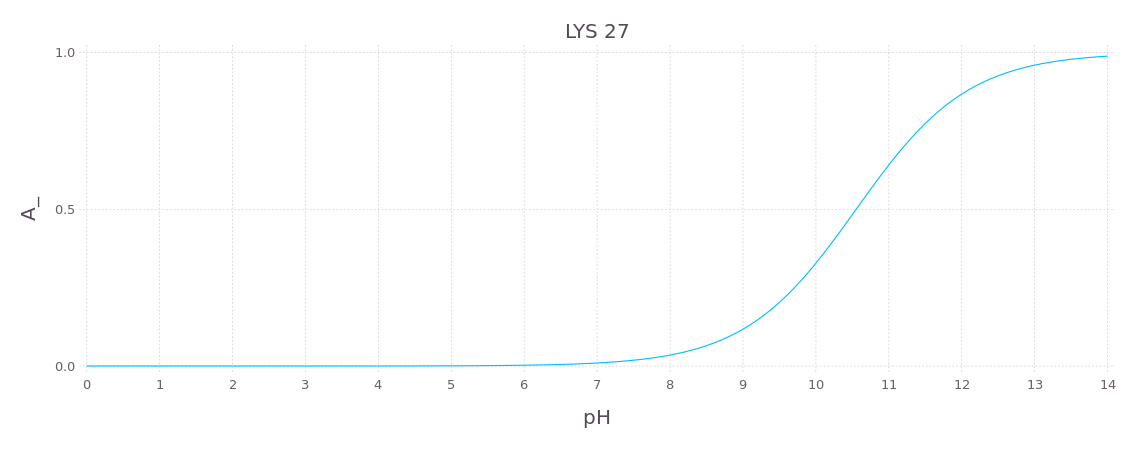

In [19]:
i = 9
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

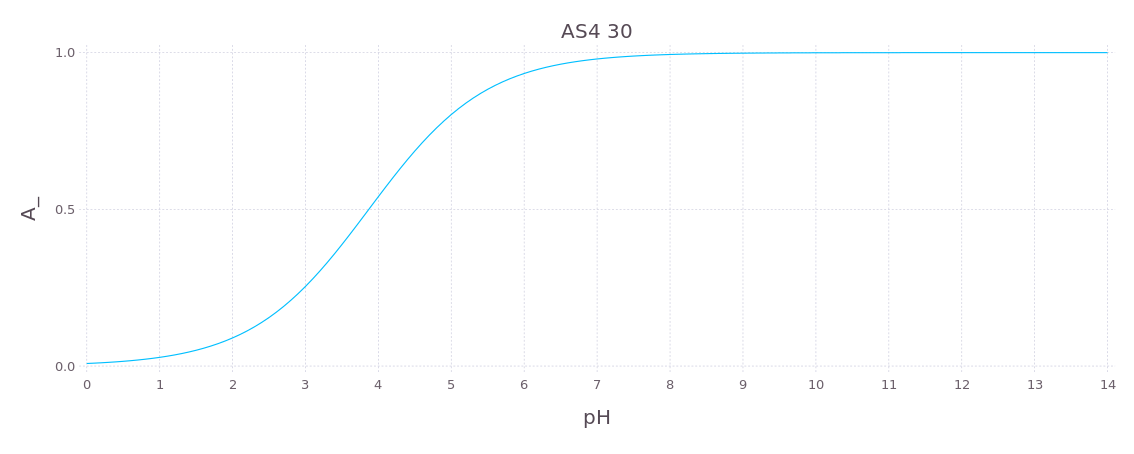

In [20]:
i = 10
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

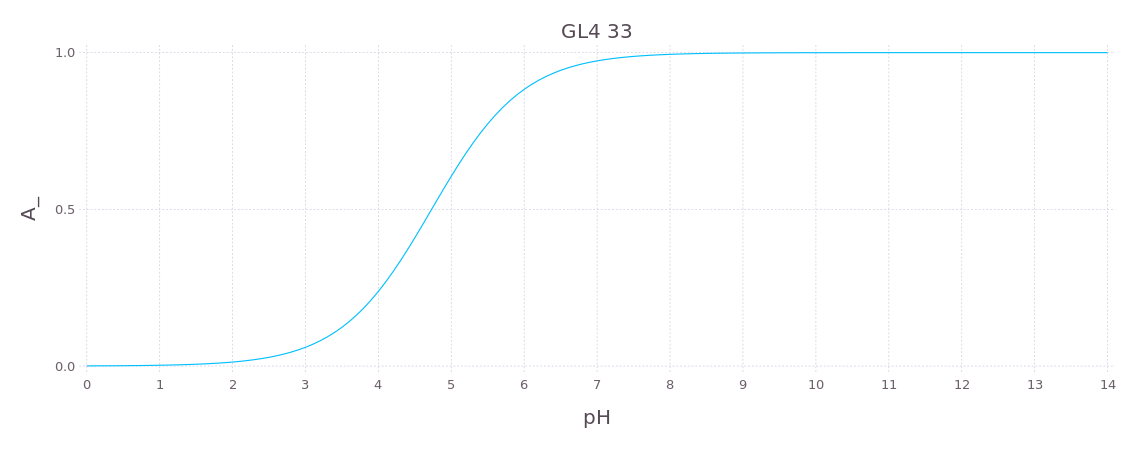

In [21]:
i = 11
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

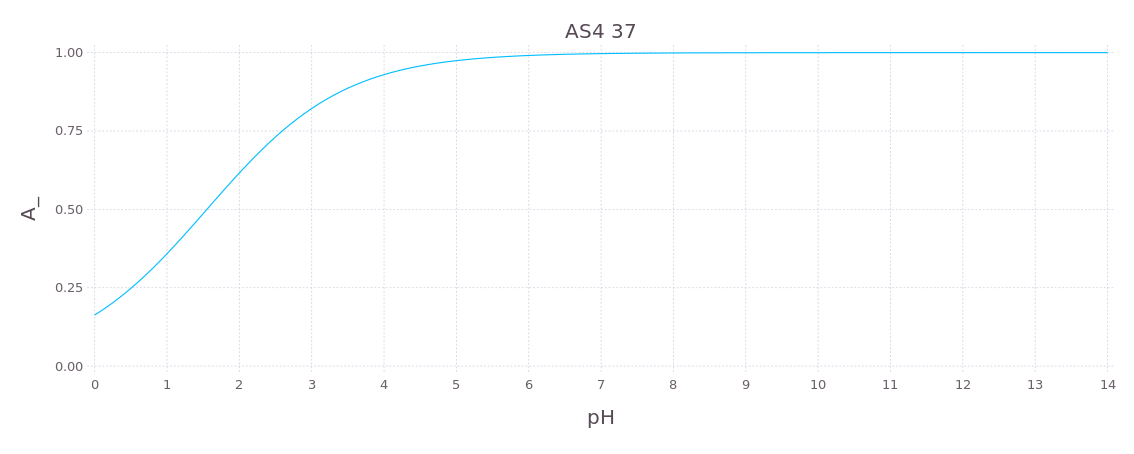

In [22]:
i = 12
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

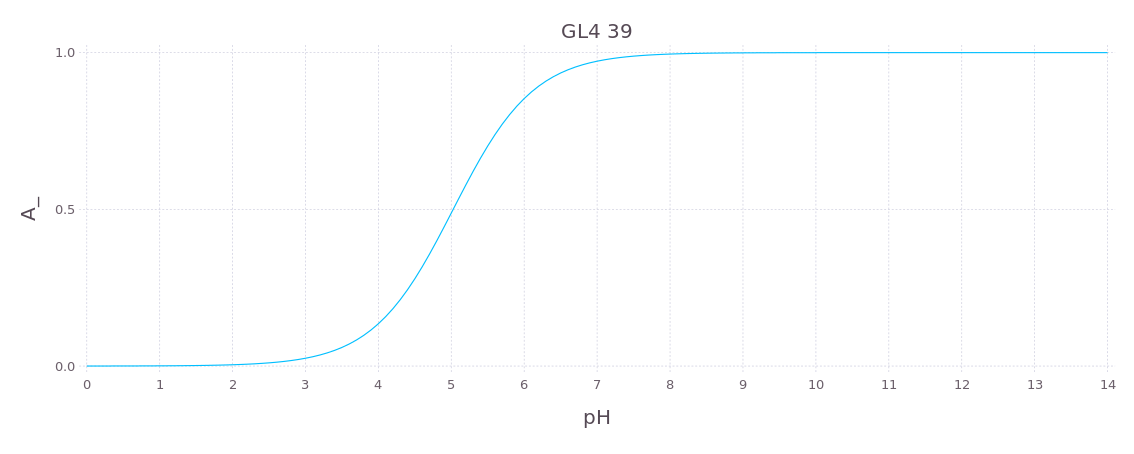

In [23]:
i = 13
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

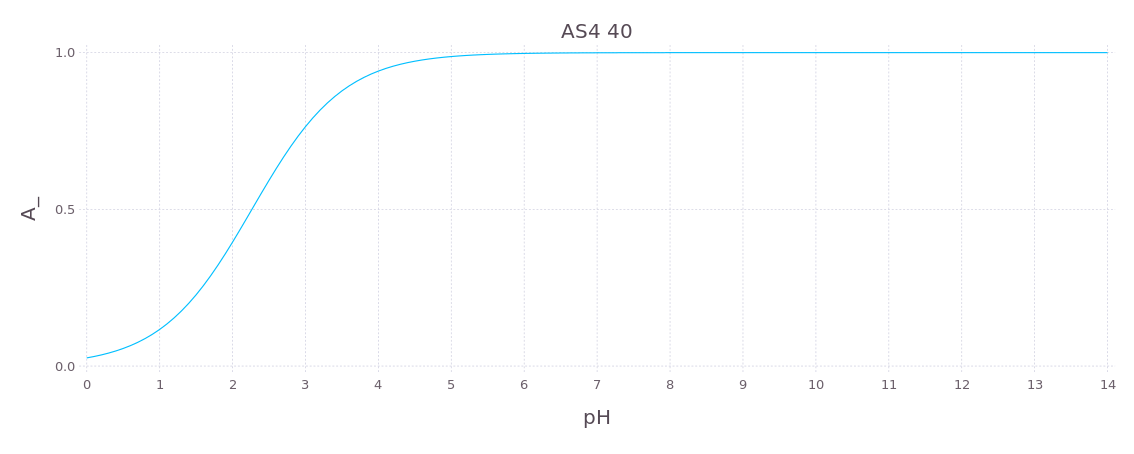

In [24]:
i = 14
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

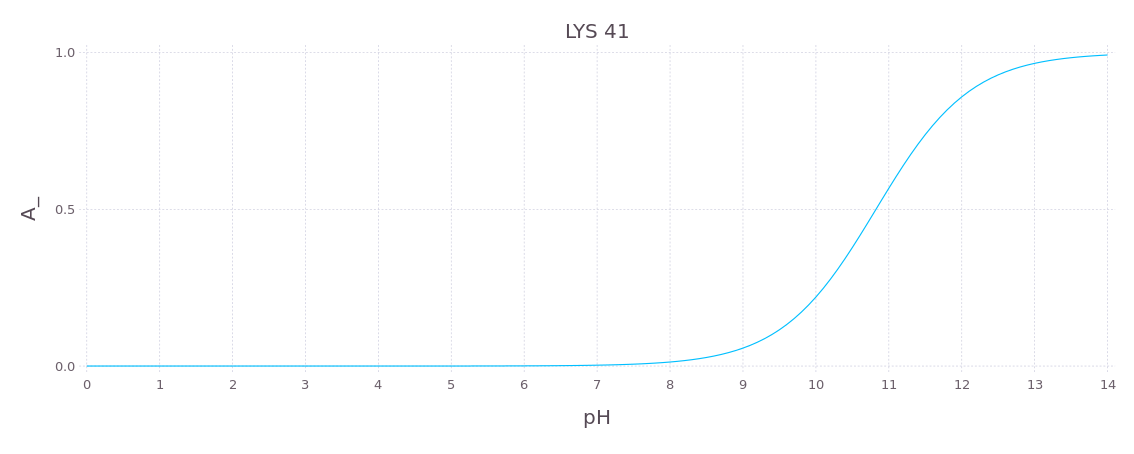

In [25]:
i = 15
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

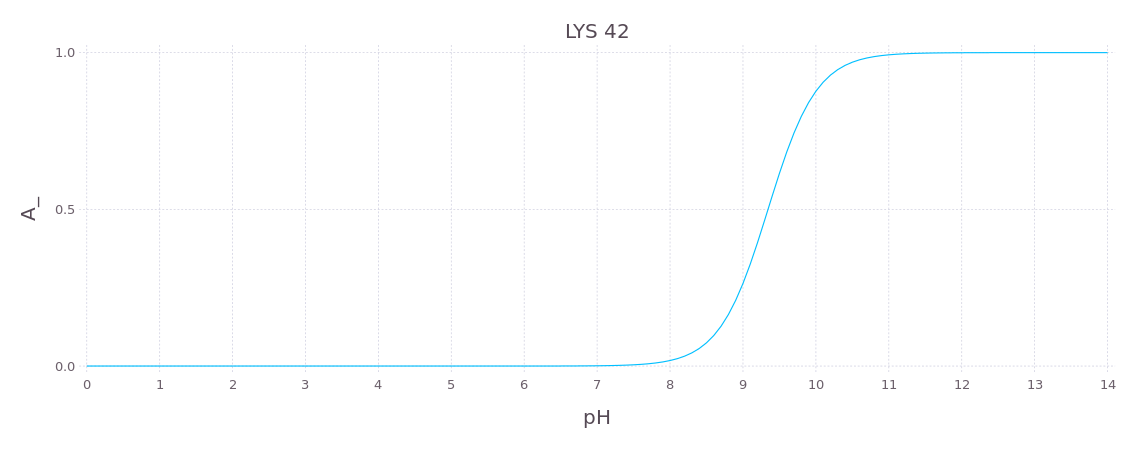

In [26]:
i = 16
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

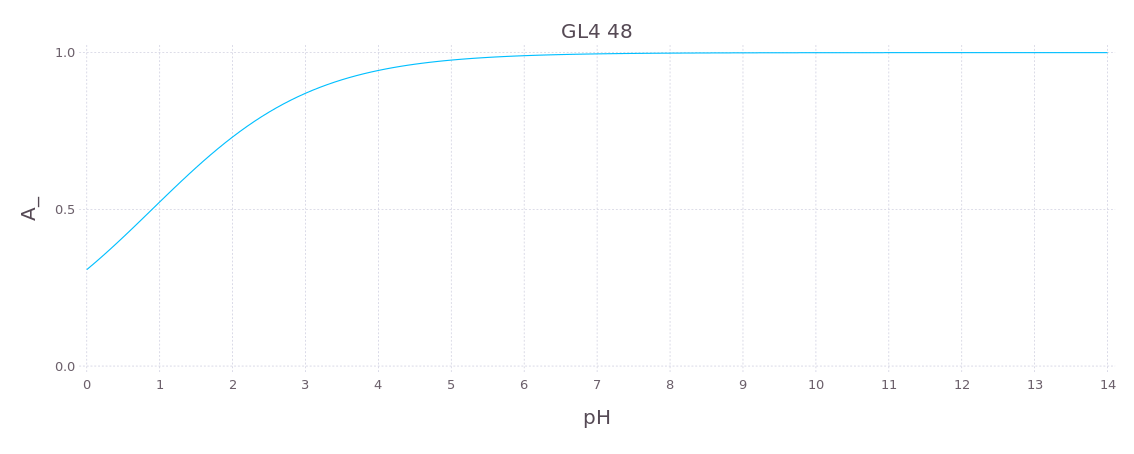

In [27]:
i = 17
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

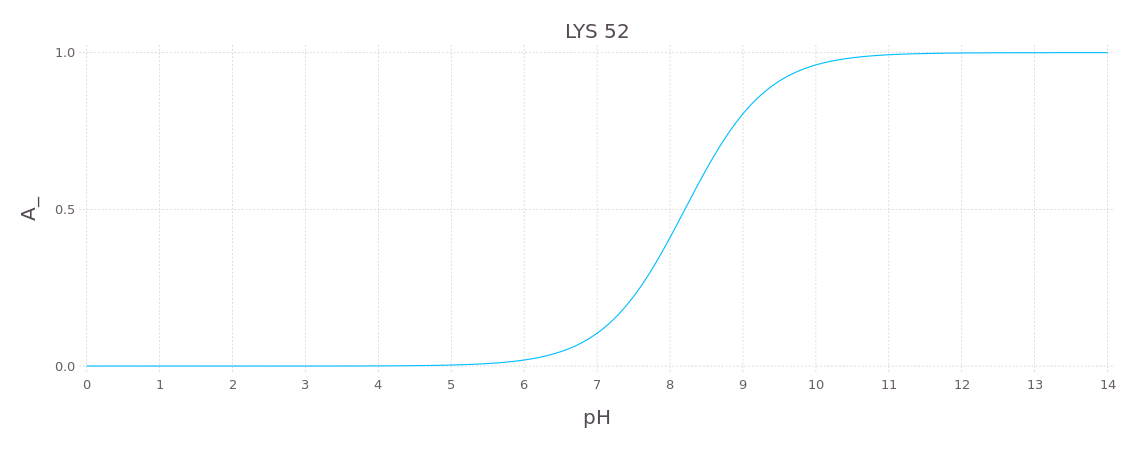

In [28]:
i = 18
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

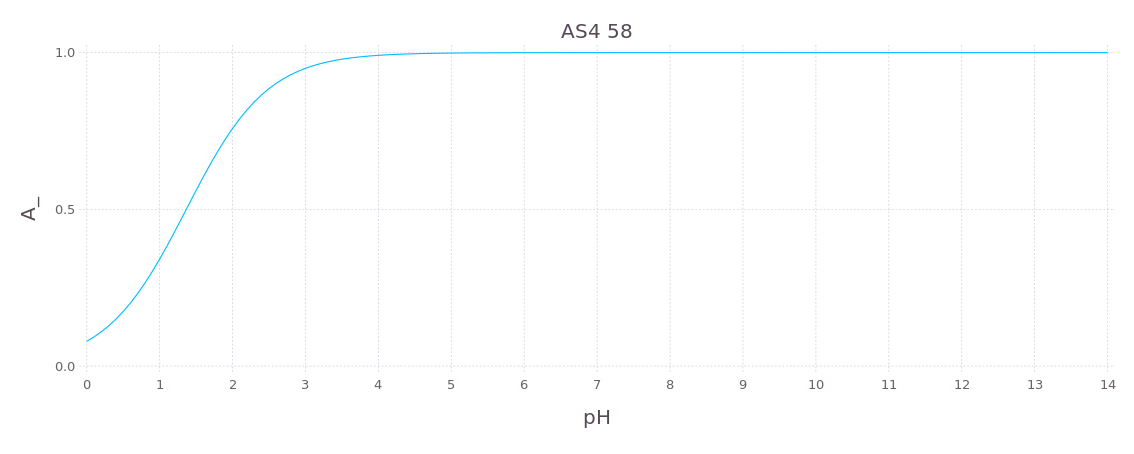

In [29]:
i = 19
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

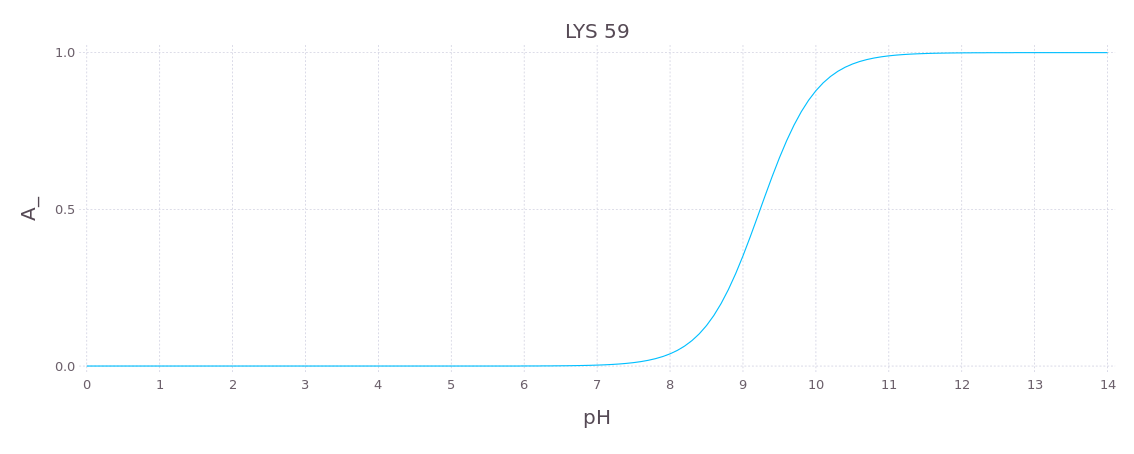

In [30]:
i = 20
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

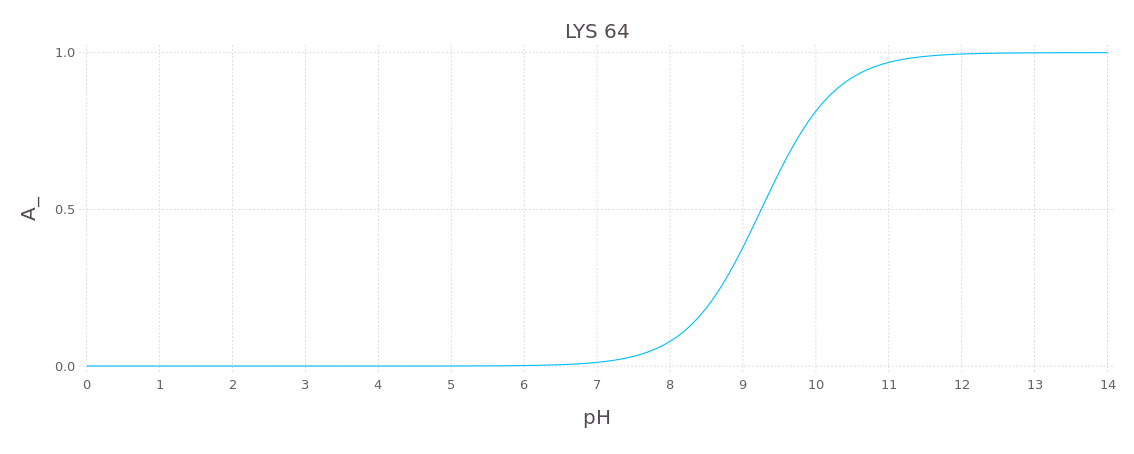

In [31]:
i = 21
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

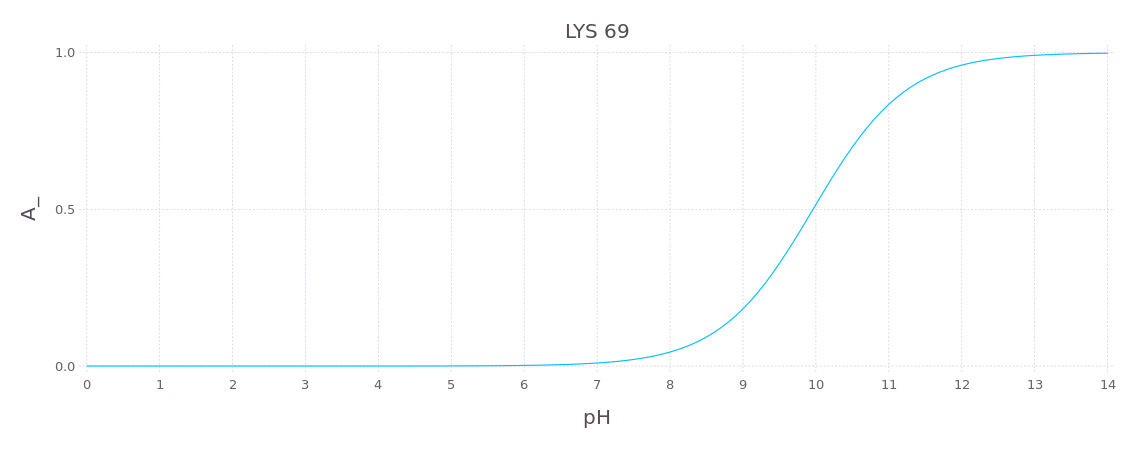

In [32]:
i = 22
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

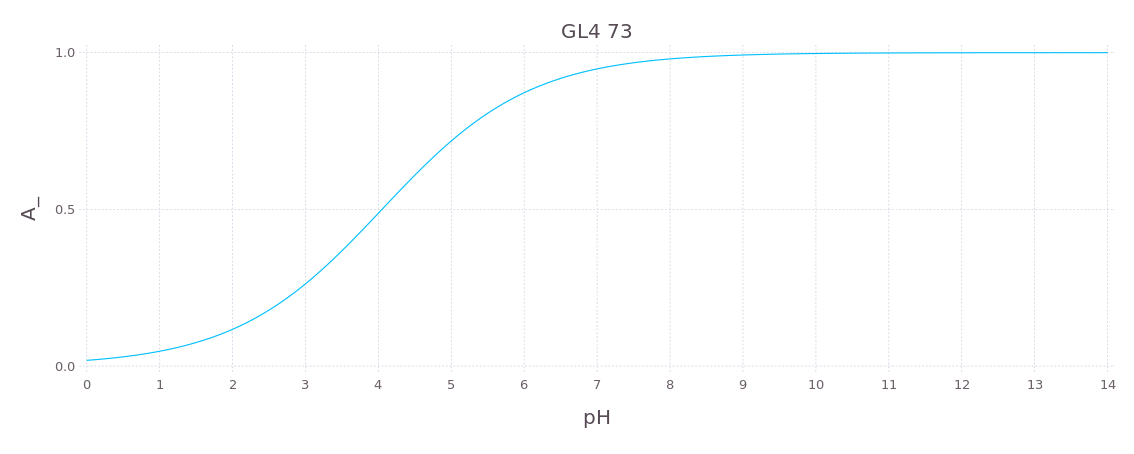

In [33]:
i = 23
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

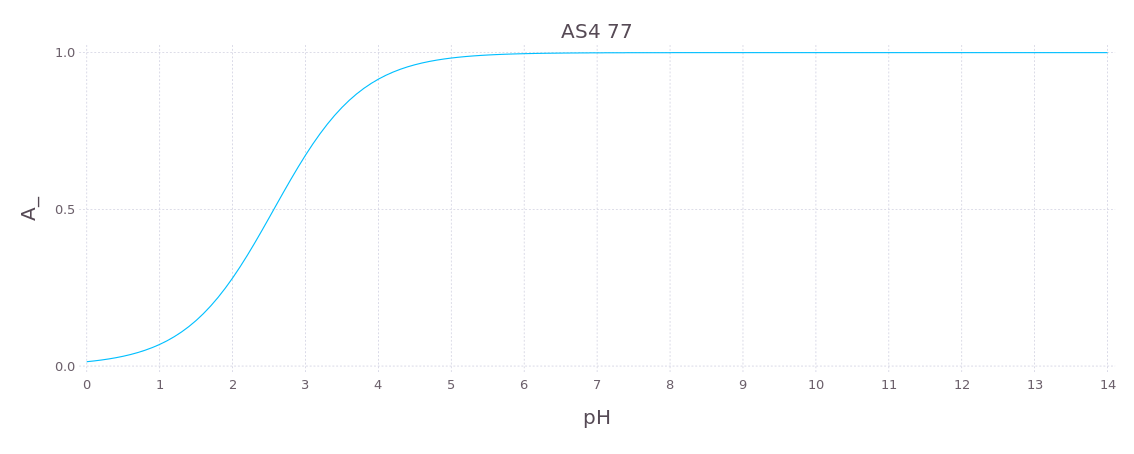

In [34]:
i = 24
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

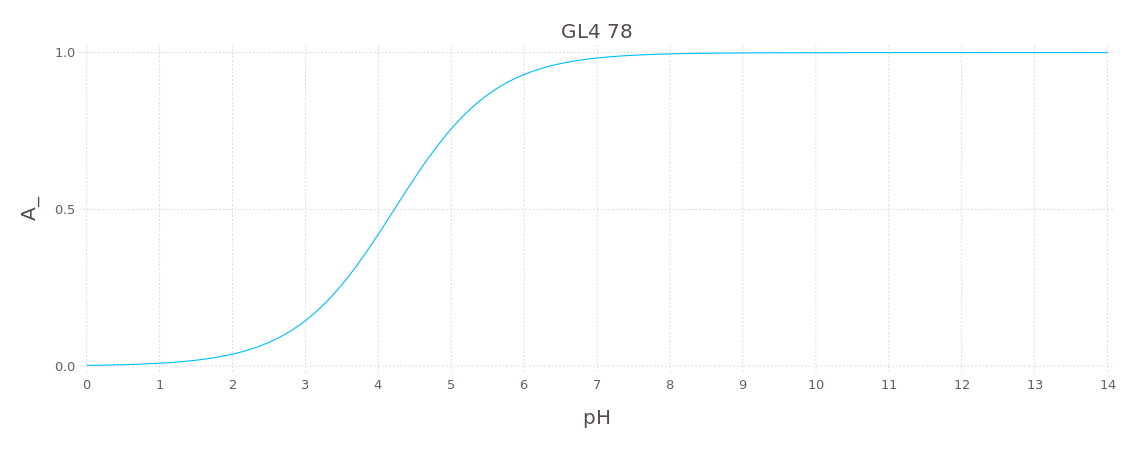

In [35]:
i = 25
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

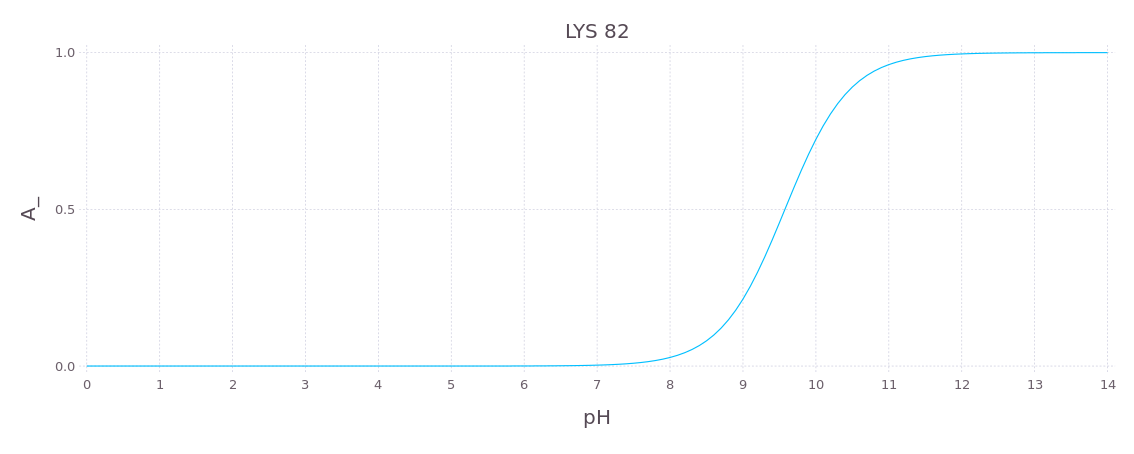

In [36]:
i = 26
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

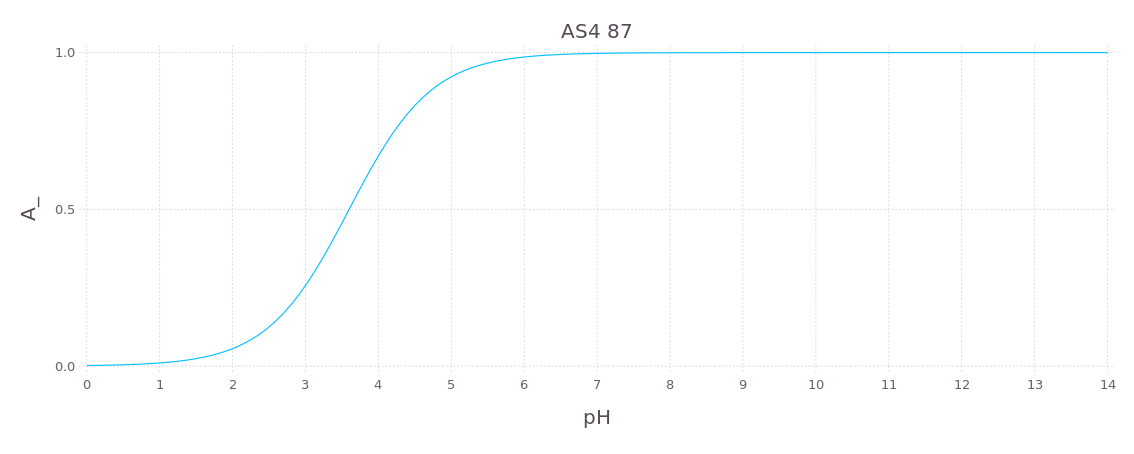

In [37]:
i = 27
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

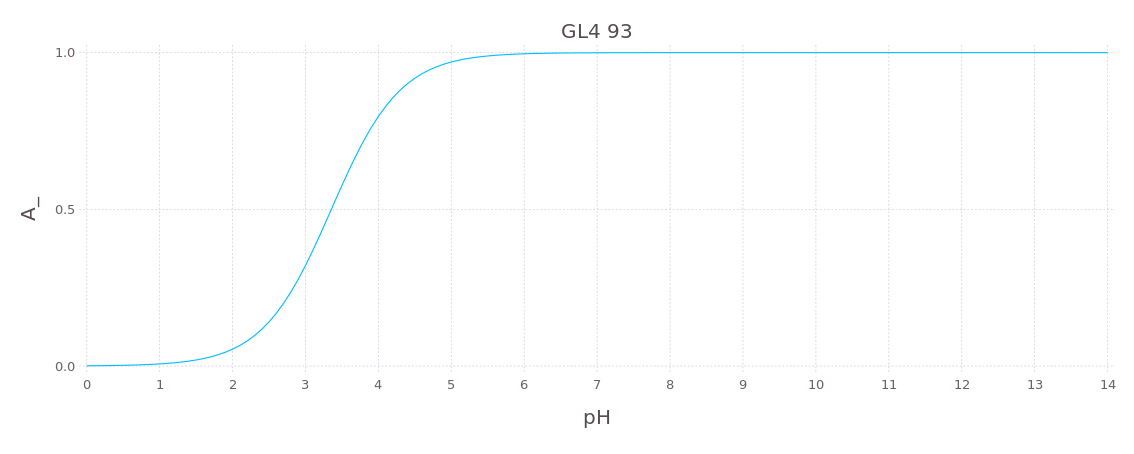

In [38]:
i = 28
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

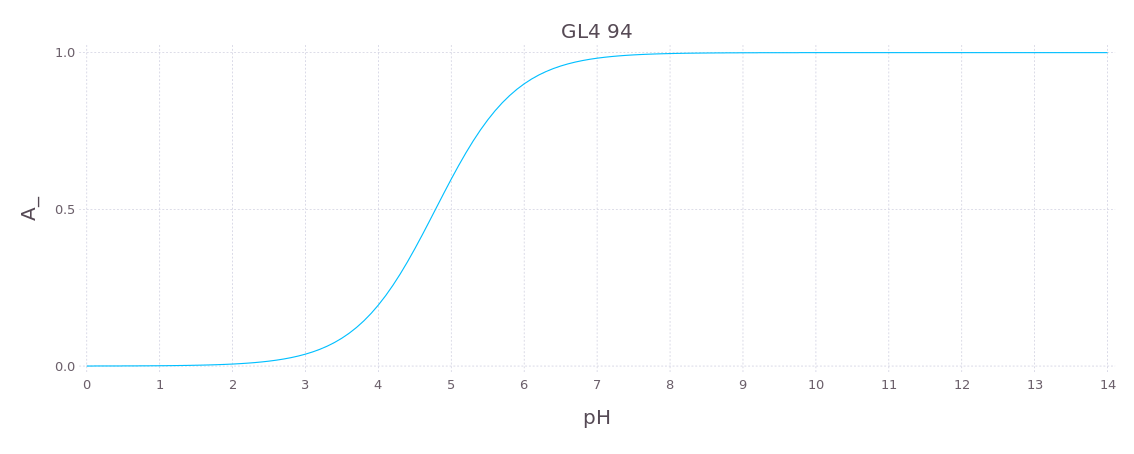

In [39]:
i = 29
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

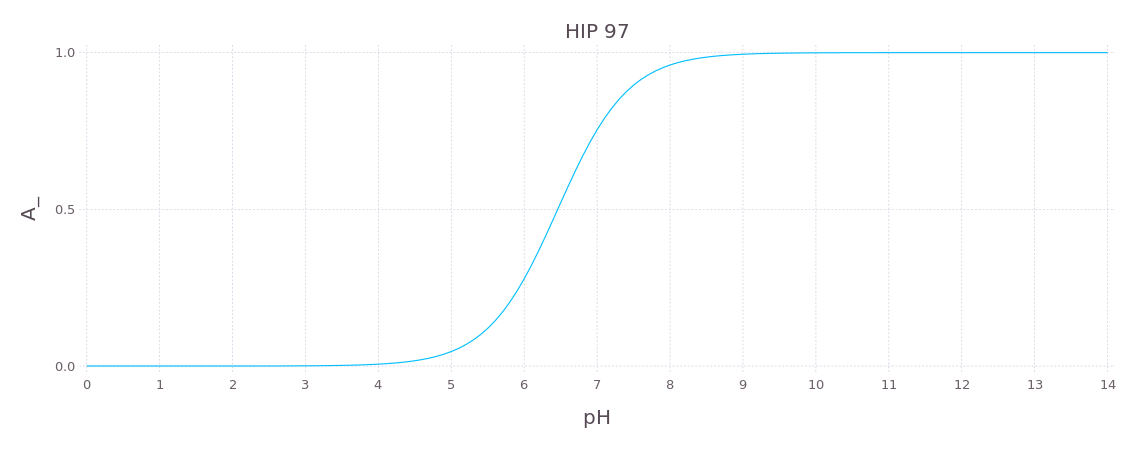

In [40]:
i = 30
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

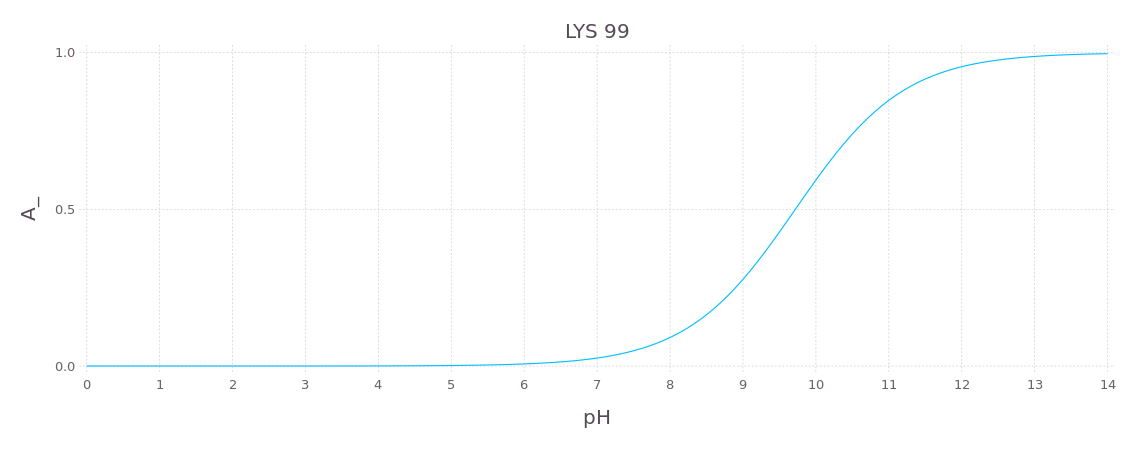

In [41]:
i = 31
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

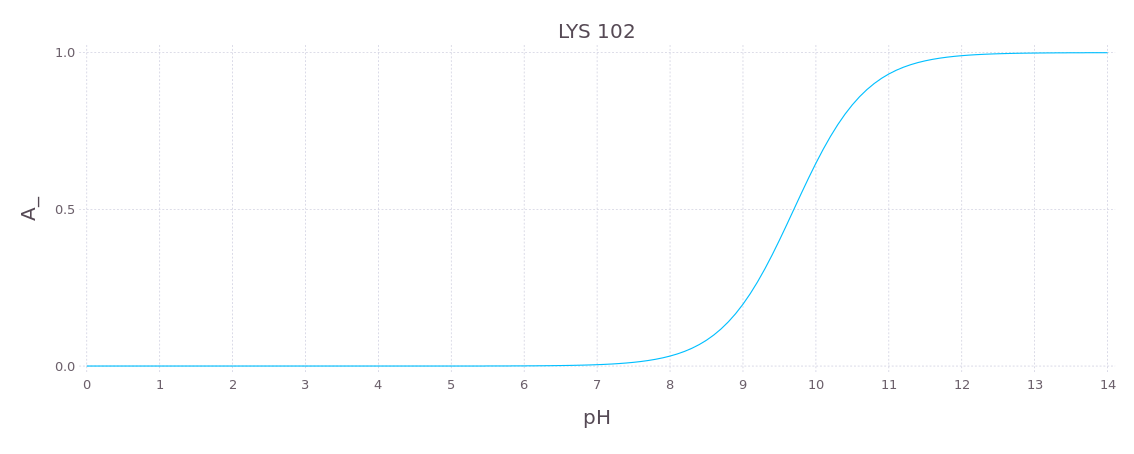

In [42]:
i = 32
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

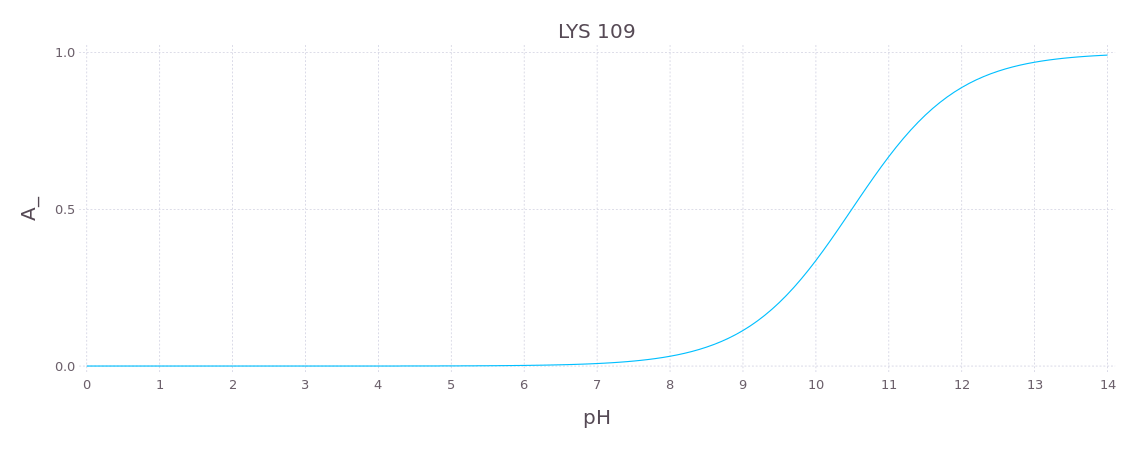

In [43]:
i = 33
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

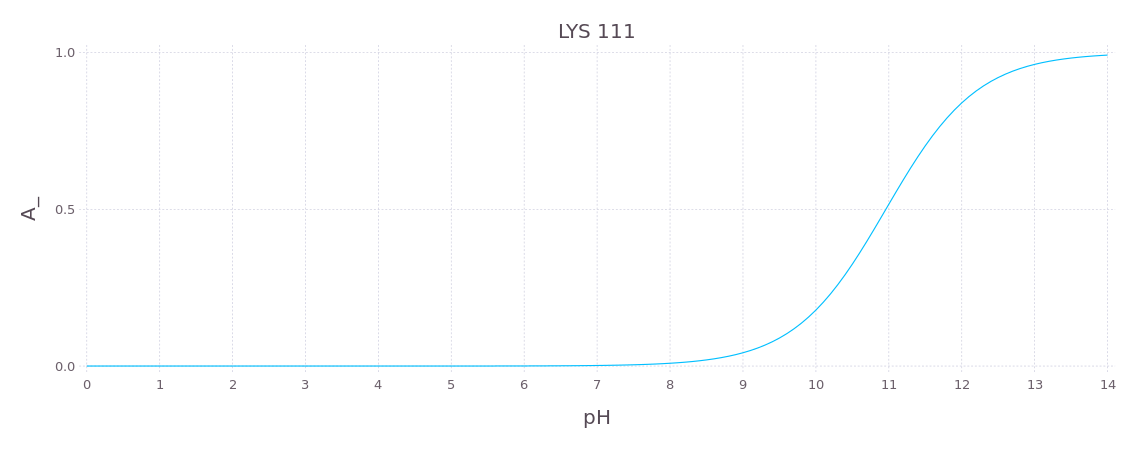

In [44]:
i = 34
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

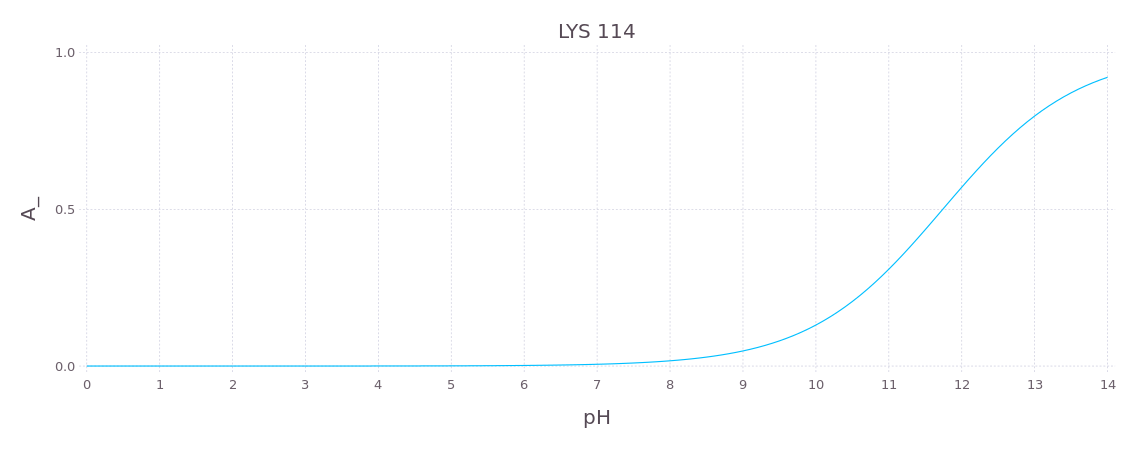

In [45]:
i = 35
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))

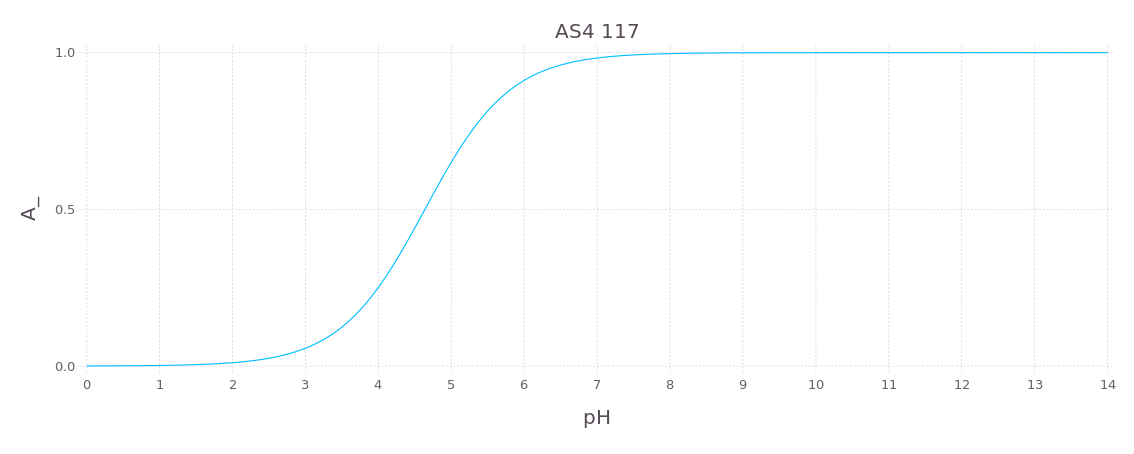

In [46]:
i = 36
plot(DataFrame(A_ = titrable_curves[i](x), pH = x), y = "A_", Geom.line, x = "pH",
    
Guide.title(string(titrable_resnames[i], " ", titrable_resis[i])),
Guide.xticks(ticks = collect(0.0:1:14.0)),
    
Theme(minor_label_font_size = 10pt, major_label_font_size = 15pt,
key_title_font_size=20pt, key_label_font_size=20pt))